In [ ]:
!pip install opencv-python-headless

#Preprocessing and Feature Extraction

In [ ]:
import os
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from skimage.feature import hog
from skimage import exposure
import os
import cv2
import numpy as np
from skimage import exposure

# Resize images to a consistent size
def resize_images(images, new_size=(100, 100)):
    resized_images = []
    for img in images:
        resized = cv2.resize(img, new_size)  # Resize image
        resized_images.append(resized)
    return resized_images

def preprocess_images(images):
    preprocessed_images = []
    for img in images:
        # Convert RGB image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Normalize pixel values to the range [0, 1]
        normalized_img = gray_img / 255.0

        # Resize image to a consistent size (e.g., 100x100)
        resized_img = cv2.resize(normalized_img, (100, 100))

        # Apply histogram equalization
        equalized_img = exposure.equalize_hist(resized_img)

        preprocessed_images.append(equalized_img)
    return preprocessed_images

# Resize images to a consistent size (e.g., 100x100)
resized_images = resize_images(images, new_size=(100, 100))

preprocessed_images = preprocess_images(resized_images)

#Load Dataset

In [ ]:
# Function to load images from directory
def load_images_from_folder(folder):
    images = []
    labels = []
    for emotion_class in os.listdir(folder):
        class_folder = os.path.join(folder, emotion_class)
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(emotion_class)  # Assuming class names are folder names
    return images, labels

# Load images from directory
data_folder = '/content/drive/MyDrive/Dataset/Train'
images, labels = load_images_from_folder(data_folder)

#Feature Extraction

In [ ]:
import os
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from skimage.feature import hog
from skimage import exposure

# Feature extraction using HOG
hog_features = []
for img in preprocessed_images:
    hog_img = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), multichannel=False)
    hog_features.append(hog_img)

# Convert to numpy array
X = np.array(hog_features)

<ipython-input-4-5811ef06832e>:14: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_img = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), multichannel=False)


In [ ]:
print(len(X))  # Check the number of samples in X
print(len(numeric_labels))  # Check the number of samples in numeric_labels

770
770


In [ ]:
from sklearn.preprocessing import LabelEncoder
# Get class names from directory names
class_names = sorted(os.listdir(data_folder))

# Convert labels to numeric values using LabelEncoder
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

# Split data into train and test sets
X_train_unsampled, X_test, y_train_unsampled, y_test = train_test_split(X, numeric_labels, test_size=0.2, random_state=42)

# Apply Random Oversampling only on the training set
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train_unsampled, y_train_unsampled)


In [ ]:
from collections import Counter

# Assuming train_labels and test_labels contain the labels for train and test data respectively
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

print("Train dataset class distribution:")
print(train_label_counts)

print("\nTest dataset class distribution:")
print(test_label_counts)

Train dataset class distribution:
Counter({'joy': 416, 'Natural': 165, 'anger': 66, 'fear': 44})

Test dataset class distribution:
Counter({'joy': 47, 'Natural': 19, 'anger': 8, 'fear': 5})


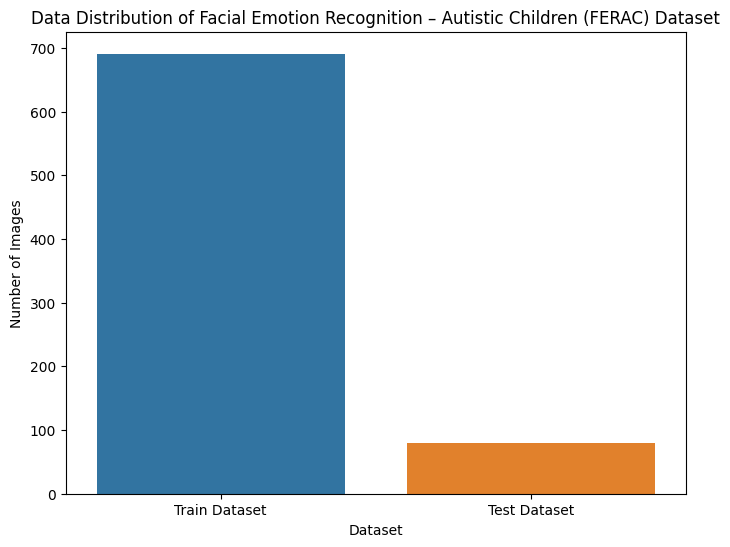

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the number of images in train and test datasets
train_images_count = len(X_train)
test_images_count = len(X_test)

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=['Train Dataset', 'Test Dataset'], y=[train_images_count, test_images_count])
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Data Distribution of Facial Emotion Recognition – Autistic Children (FERAC) Dataset')
plt.show()


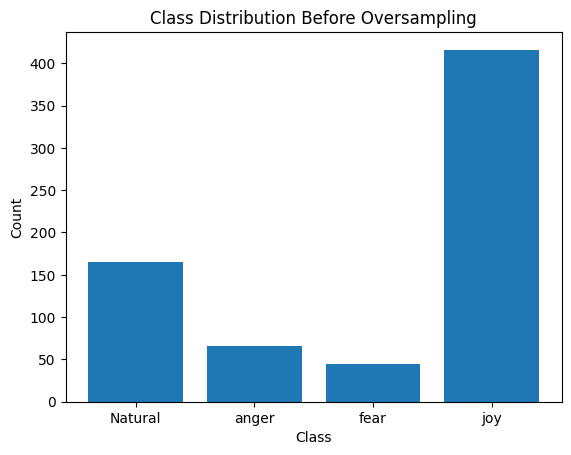

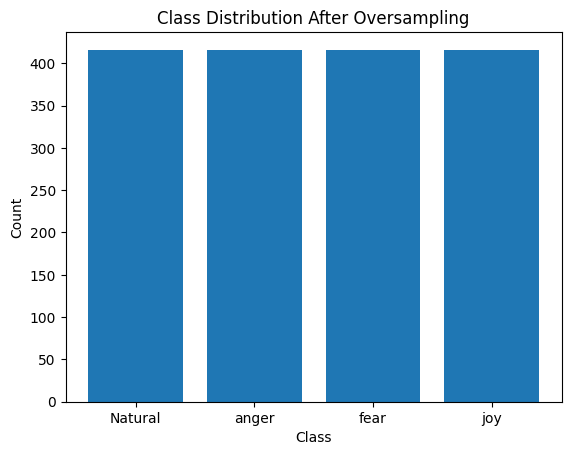

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your class names
class_names = ['Natural', 'anger', 'fear', 'joy']  # Replace with your actual class names

# Function to visualize class histograms with class names
def plot_class_histogram(y, title, class_names):
    unique, counts = np.unique(y, return_counts=True)
    plt.bar(class_names, counts)  # Use class_names for x-axis
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if needed
    plt.show()

# Example usage:
# Visualize class histogram before oversampling
plot_class_histogram(y_train, 'Class Distribution Before Oversampling', class_names)

# Visualize class histogram after oversampling
plot_class_histogram(y_train_resampled, 'Class Distribution After Oversampling', class_names)



#Random Forest

In [ ]:
# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Convert numeric predictions back to original labels
predicted_labels = label_encoder.inverse_transform(y_pred_rf)
y_test_labels = label_encoder.inverse_transform(y_test)

# Evaluate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")

# Generate classification report
from sklearn.metrics import classification_report
class_report = classification_report(y_test_labels, predicted_labels, target_names=class_names, zero_division=1)

print("Classification Report for Random Forest:")
print(class_report)

Random Forest Accuracy: 0.5949367088607594
Classification Report for Random Forest:
              precision    recall  f1-score   support

     Natural       1.00      0.00      0.00        19
       anger       1.00      0.00      0.00         8
        fear       1.00      0.00      0.00         5
         joy       0.59      1.00      0.75        47

    accuracy                           0.59        79
   macro avg       0.90      0.25      0.19        79
weighted avg       0.76      0.59      0.44        79



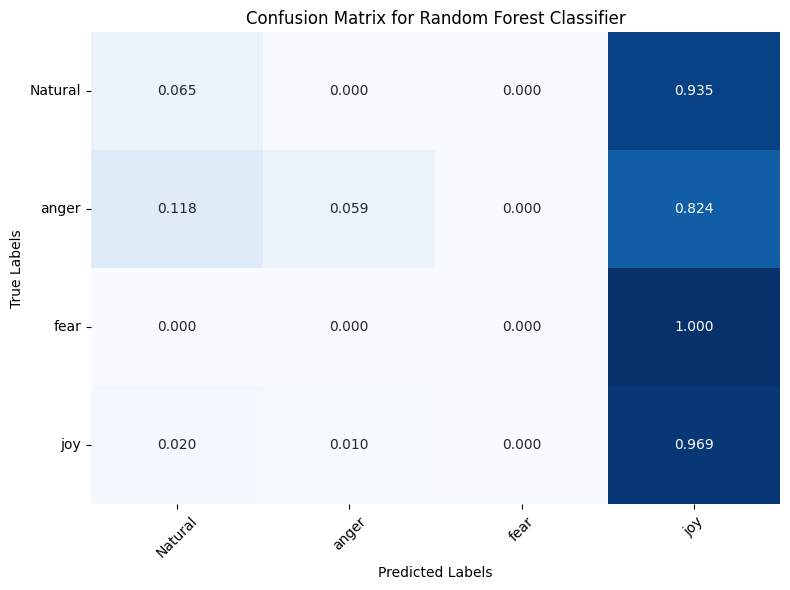

Classification Report:
              precision    recall  f1-score   support

     Natural       0.33      0.06      0.11        31
       anger       0.50      0.06      0.11        17
        fear       0.00      0.00      0.00         8
         joy       0.65      0.97      0.78        98

    accuracy                           0.64       154
   macro avg       0.37      0.27      0.25       154
weighted avg       0.54      0.64      0.53       154



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get the confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test_labels, predicted_labels)

# Calculate percentages for confusion matrix
conf_matrix_rf_percent = conf_matrix_rf / conf_matrix_rf.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix for Random Forest in percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf_percent, annot=True, fmt=".3f", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Generate classification report
print("Classification Report:")
print(classification_report(y_test_labels, predicted_labels))

#Polynomial SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Initialize Polynomial SVM Classifier
poly_svm_classifier = SVC(kernel='poly', degree=3, C=1.0, random_state=42)

# Train the Polynomial SVM classifier
poly_svm_classifier.fit(X_train, y_train)

# Predict on the test set for Polynomial SVM
y_pred_poly_svm = poly_svm_classifier.predict(X_test)
y_test_labels = label_encoder.inverse_transform(y_test)

# Evaluate accuracy for Polynomial SVM
accuracy_poly_svm = accuracy_score(y_test, y_pred_poly_svm)
print(f"Polynomial SVM Accuracy: {accuracy_poly_svm}")

# Generate classification report for Polynomial SVM
class_report_poly_svm = classification_report(y_test_labels, label_encoder.inverse_transform(y_pred_poly_svm), target_names=class_names)
print("Classification Report for Polynomial SVM:")
print(class_report_poly_svm)

Polynomial SVM Accuracy: 0.5584415584415584
Classification Report for Polynomial SVM:
              precision    recall  f1-score   support

     Natural       0.23      0.29      0.26        31
       anger       0.22      0.12      0.15        17
        fear       0.33      0.25      0.29         8
         joy       0.73      0.74      0.74        98

    accuracy                           0.56       154
   macro avg       0.38      0.35      0.36       154
weighted avg       0.55      0.56      0.55       154



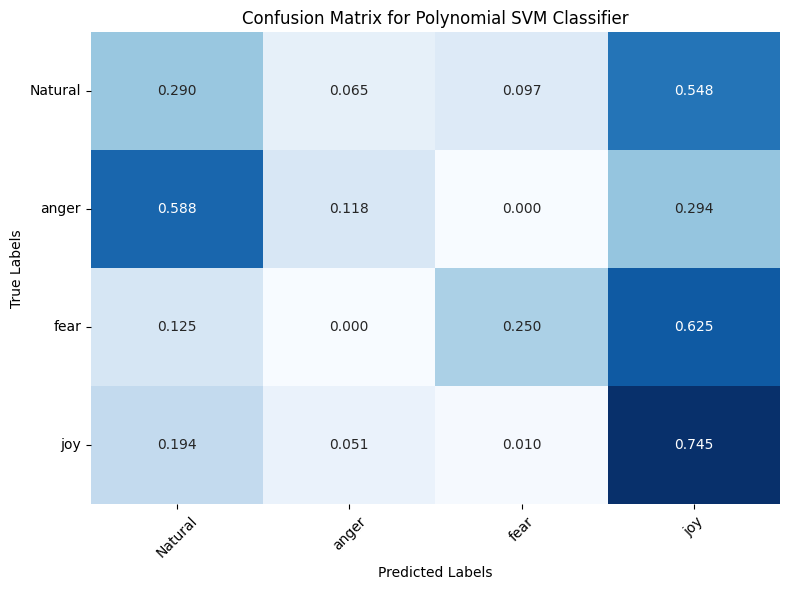

Classification Report:
               precision    recall  f1-score   support

     Natural       0.23      0.29      0.26        31
       anger       0.22      0.12      0.15        17
        fear       0.33      0.25      0.29         8
         joy       0.73      0.74      0.74        98

    accuracy                           0.56       154
   macro avg       0.38      0.35      0.36       154
weighted avg       0.55      0.56      0.55       154



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
conf_matrix_svm = confusion_matrix(y_test_labels, label_encoder.inverse_transform(y_pred_poly_svm))

# Calculate classification report
report = classification_report(y_test_labels, label_encoder.inverse_transform(y_pred_poly_svm))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm / conf_matrix_svm.sum(axis=1)[:, np.newaxis], annot=True, fmt=".3f", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Polynomial SVM Classifier')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Display classification report
print("Classification Report:\n", report)

#Linear - SVM

In [ ]:
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Initialize SVM Classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Predict on the test set for SVM
y_pred_svm = svm_classifier.predict(X_test)

# Evaluate accuracy for SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm}")

# Generate classification report for SVM
class_report_svm = classification_report(y_test_labels, label_encoder.inverse_transform(y_pred_svm), target_names=class_names)
print("Classification Report for SVM:")
print(class_report_svm)


SVM Accuracy: 0.512987012987013
Classification Report for SVM:
              precision    recall  f1-score   support

     Natural       0.23      0.32      0.27        31
       anger       0.19      0.18      0.18        17
        fear       0.10      0.12      0.11         8
         joy       0.76      0.66      0.71        98

    accuracy                           0.51       154
   macro avg       0.32      0.32      0.32       154
weighted avg       0.56      0.51      0.53       154



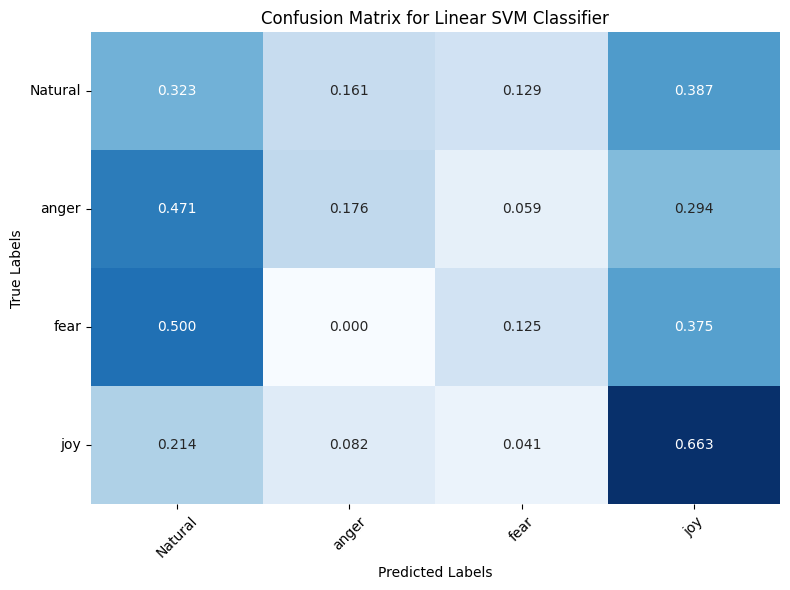

Classification Report:
               precision    recall  f1-score   support

     Natural       0.23      0.32      0.27        31
       anger       0.19      0.18      0.18        17
        fear       0.10      0.12      0.11         8
         joy       0.76      0.66      0.71        98

    accuracy                           0.51       154
   macro avg       0.32      0.32      0.32       154
weighted avg       0.56      0.51      0.53       154



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate confusion matrix
conf_matrix_svm = confusion_matrix(y_test_labels, label_encoder.inverse_transform(y_pred_svm))

# Calculate confusion matrix in percentage
conf_matrix_percentage = conf_matrix_svm / conf_matrix_svm.sum(axis=1)[:, np.newaxis]

# Calculate classification report
report = classification_report(y_test_labels, label_encoder.inverse_transform(y_pred_svm))

# Plot confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".3f", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Linear SVM Classifier')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Display classification report
print("Classification Report:\n", report)

#XGBOOST

In [ ]:
# Initialize XGBoost Classifier
xgb_classifier = XGBClassifier(random_state=42)

# Train the XGBoost classifier
xgb_classifier.fit(X_train, y_train)

# Predict on the test set for XGBoost
y_pred_xgb = xgb_classifier.predict(X_test)

# Evaluate accuracy for XGBoost
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb}")

# Generate classification report for XGBoost
class_report_xgb = classification_report(y_test_labels, label_encoder.inverse_transform(y_pred_xgb), target_names=class_names)
print("Classification Report for XGBoost:")
print(class_report_xgb)

XGBoost Accuracy: 0.6103896103896104
Classification Report for XGBoost:
              precision    recall  f1-score   support

     Natural       0.28      0.29      0.29        31
       anger       0.00      0.00      0.00        17
        fear       0.00      0.00      0.00         8
         joy       0.74      0.87      0.80        98

    accuracy                           0.61       154
   macro avg       0.26      0.29      0.27       154
weighted avg       0.53      0.61      0.57       154



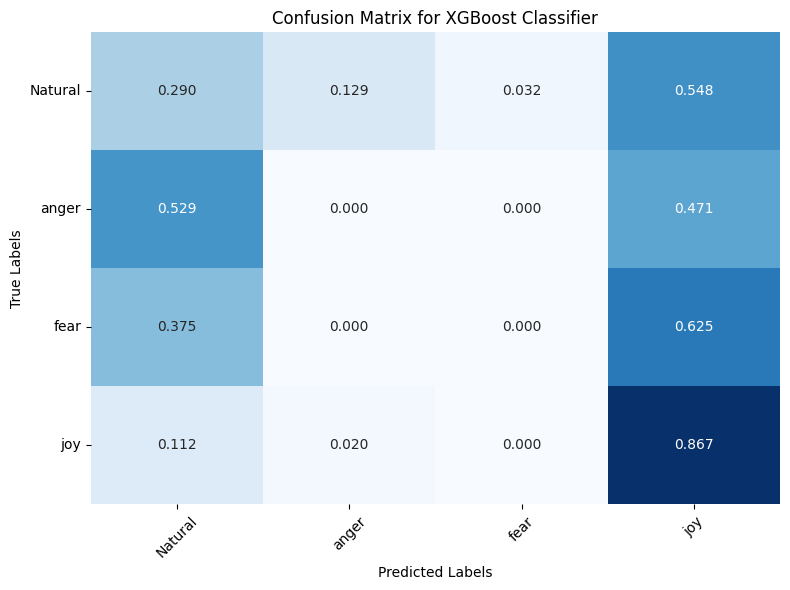

Classification Report:
               precision    recall  f1-score   support

     Natural       0.28      0.29      0.29        31
       anger       0.00      0.00      0.00        17
        fear       0.00      0.00      0.00         8
         joy       0.74      0.87      0.80        98

    accuracy                           0.61       154
   macro avg       0.26      0.29      0.27       154
weighted avg       0.53      0.61      0.57       154



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate confusion matrix
conf_matrix_svm = confusion_matrix(y_test_labels, label_encoder.inverse_transform(y_pred_xgb))

# Calculate confusion matrix in percentage
conf_matrix_percentage = conf_matrix_svm / conf_matrix_svm.sum(axis=1)[:, np.newaxis]

# Calculate classification report
report = classification_report(y_test_labels, label_encoder.inverse_transform(y_pred_xgb))

# Plot confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".3f", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for XGBoost Classifier')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Display classification report
print("Classification Report:\n", report)